<a href="https://colab.research.google.com/github/Zach227/temp_files/blob/main/proj3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
%%bash
cd /
mv data.zip content
mv custom_dataset.py content
cd content
unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: data/test/
  inflating: data/test/mimage(60).jpg  
  inflating: data/test/ggimage(74).jpg  
  inflating: data/test/pimage(63).jpg  
  inflating: data/test/nimage(35).jpg  
  inflating: data/test/mimage(37).jpg  
  inflating: data/test/ggimage(23).jpg  
  inflating: data/test/pimage(34).jpg  
  inflating: data/test/nimage(62).jpg  
  inflating: data/test/mimage(21).jpg  
  inflating: data/test/ggimage(35).jpg  
  inflating: data/test/pimage(22).jpg  
  inflating: data/test/nimage(74).jpg  
  inflating: data/test/mimage(76).jpg  
  inflating: data/test/ggimage(62).jpg  
  inflating: data/test/mimage(99).jpg  
  inflating: data/test/nimage(23).jpg  
  inflating: data/test/ggimage(19).jpg  
  inflating: data/test/nimage(58).jpg  
  inflating: data/test/mimage(6).jpg  
  inflating: data/test/mimage.jpg    
  inflating: data/test/nimage(100).jpg  
  inflating: data/test/ggimage(58).jpg  
  inflating: dat

mv: cannot stat 'data.zip': No such file or directory
mv: cannot stat 'custom_dataset.py': No such file or directory


## Create Datasets

In [11]:
from custom_dataset import CustomImageDataset
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [
        transforms.Resize((240, 240)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
batch_size = 2

train_data = CustomImageDataset(
    "data/train/train.csv", "data/train/", transform=transform
)
test_dataset = CustomImageDataset(
    "data/test/test.csv", "data/test/", transform=transform
)

train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_data, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


classes = ["None", "glioma", "meningioma", "pituitary"]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


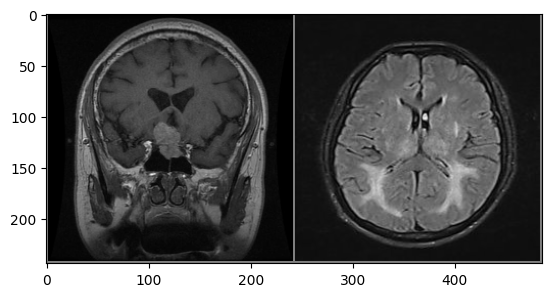

pituitary None 
torch.Size([2, 3, 240, 240])


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# image, label = trainset.__getitem__(220)
# print(image.shape)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# # show images
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))
print(images.shape)

## Dummy Classifier

In [5]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier('most_frequent')

TypeError: ignored

## Define Networks

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 30 * 30, 512)  # Adjust the input size based on your image dimensions
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 256 * 30 * 30)  # Adjust the size based on your image dimensions

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [8]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 15 * 15, 1024)
        self.fc2 = nn.Linear(1024, 4)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 512 * 15 * 15)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class WiderCNN(nn.Module):
    def __init__(self):
        super(WiderCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 15 * 15, 1024)
        self.fc2 = nn.Linear(1024, 4)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 512 * 15 * 15)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


## Hyperparameter Sweep

In [ ]:
import torch.optim as optim

results_dict = {}
for criterion in [nn.CrossEntropyLoss()]:
  for learning_rate in [0.001]:
    for opt in ['Adam', 'SGD', 'RMSprop']:

      model = CNN()
      if opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
      elif opt == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      elif opt == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)


      device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      model.to(device)

      val_stats = []
      for epoch in range(15):  # loop over the dataset multiple times
          for i, data in enumerate(train_loader, 0):
              # get the inputs; data is a list of [inputs, labels]
              inputs, labels = data[0].to(device), data[1].to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward + backward + optimize
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

          # Validation
          correct = 0
          total = 0
          with torch.no_grad():
              for data in val_loader:
                  inputs, labels = data[0].to(device), data[1].to(device)
                  outputs = model(inputs)
                  _, predicted = torch.max(outputs.data, 1)  # returns max value, indices
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
          accuracy = 100 * correct / total
          hyp_params = f'batch_size={batch_size}, criterion={criterion}, learning rate={learning_rate}, optimizer = {opt}, epochs = {epoch+1}'
          results_dict[hyp_params] = accuracy
          print(f'{hyp_params} ---> {accuracy}')

In [ ]:
PATH = "./proj3_model.pth"
torch.save(model.state_dict(), PATH)

/Users/zacharydriskill/Desktop/ECEN493/envML/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


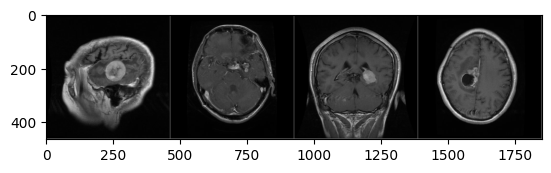

GroundTruth:  meningioma glioma meningioma glioma
Predicted:  meningioma glioma pituitary meningioma


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))


net = CNN()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test images: {100 * correct // total} %")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on the test images: 69 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy for class: None  is 91.4 %
Accuracy for class: glioma is 21.0 %
Accuracy for class: meningioma is 87.8 %
Accuracy for class: pituitary is 73.0 %
